In [224]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.arima.model import ARIMA
from collections import defaultdict
import warnings
df = pd.read_csv("btc.csv", parse_dates=['time'])
rfr = pd.read_csv("rfr.csv", parse_dates=["observation_date"], dayfirst=True)
rfr.set_index("observation_date", inplace=True)
rfr.index = pd.to_datetime(rfr.index)
rfr = rfr[rfr.index <= pd.to_datetime("2025-04-16")]
rfr["rfr"] = np.log(rfr["rfr"]/100+1)
rfr['rfr'] = rfr['rfr'].ffill().bfill()  # fill both forward and back
crypto = pd.read_csv("crypto.csv")
crypto['snapped_at'] = pd.to_datetime(crypto["snapped_at"], unit='ms').dt.round("D")
crypto.set_index("snapped_at", inplace=True)
crypto = crypto[crypto.index <= pd.to_datetime("2025-04-16")]
df.set_index('time', inplace=True)
df = pd.merge_asof(df.sort_index(), rfr.sort_index(), left_index=True, right_index=True, direction='backward')
crypto = crypto.iloc[1:]

regimes = pd.read_csv("regimes.csv", parse_dates=["date"], dayfirst=True)
regimes.set_index('date', inplace=True)

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_40917/1545193923.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("btc.csv", parse_dates=['time'])


In [225]:
n = 30
df["ln_close"] = np.log(df["close"])
df["ln_diff"] = df["ln_close"].diff()
df['smoothed'] = df['ln_diff'].rolling(n).mean()
df = df.iloc[1:]

In [226]:
# Define halving dates
halving_dates = [
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-20")
]

In [227]:
df_weekly = df.resample("7D").agg({
    "ln_diff": "mean",    # weekly average returns
    "ln_close": "last"    # last close of the week (so the chart matches)
})

In [228]:
k = 3
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

model = MarkovRegression(df_weekly["ln_diff"], k_regimes=k, trend="c", switching_variance=True)
result = model.fit()
df_weekly["regime"] = result.smoothed_marginal_probabilities.idxmax(axis=1)

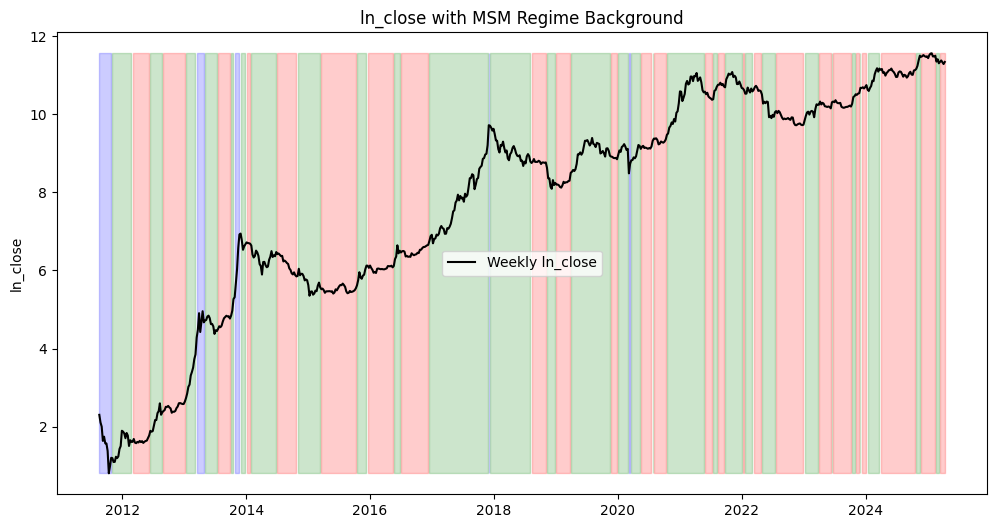

In [229]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_weekly.index, df_weekly["ln_close"], label="Weekly ln_close", color="black")

colors = ["red", "green", "blue", "orange", "purple"]  # up to k=5
for regime in range(k):
    mask = df_weekly["regime"] == regime
    ax.fill_between(df_weekly.index, df_weekly["ln_close"].min(), df_weekly["ln_close"].max(),
                    where=mask, color=colors[regime % len(colors)], alpha=0.2)

ax.set_title("ln_close with MSM Regime Background")
ax.set_ylabel("ln_close")
ax.legend()
plt.show()
